In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('/Users/daniel/Library/CloudStorage/Box-Box/Research/discrete_sr/code/SPIDER_discrete/src')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import rcParams
import h5py

from PySPIDER.continuous.library import Observable
from PySPIDER.continuous.process_library_terms import SRDataset
from PySPIDER.commons.utils import save, load

In [3]:
def load_matlab_v73(mat_file_path):
    """
    Loads MATLAB v7.3 .mat data using h5py and converts it to Python-readable formats.

    Parameters:
    - mat_file_path (str): Path to the .mat file.

    Returns:
    - dict: A dictionary with MATLAB variable names as keys and corresponding NumPy arrays as values.
    """
    try:
        # Open the HDF5 file
        with h5py.File(mat_file_path, 'r') as f:
            mat_data = {}

            def recursively_load(group):
                """
                Recursively load MATLAB v7.3 groups into dictionaries.
                """
                data = {}
                for key, item in group.items():
                    if isinstance(item, h5py.Dataset):
                        data[key] = np.array(item)  # Convert HDF5 dataset to NumPy array
                    elif isinstance(item, h5py.Group):
                        data[key] = recursively_load(item)  # Recursively process groups
                return data

            # Load all variables from the root group
            mat_data = recursively_load(f)

        return mat_data
    except Exception as e:
        print(f"Error loading .mat file: {e}")
        return None

# Path to your MATLAB v7.3 .mat file
mat_file_path = "data/filcoh_SGS.mat" # Replace with your .mat file path

In [4]:
# Load the .mat file
python_data = load_matlab_v73(mat_file_path)

# Display the loaded data
if python_data:
    for var_name, data in python_data.items():
        if isinstance(data, np.ndarray):
            print(f"Variable: {var_name}, Shape: {data.shape}, Type: {type(data)}")
        else:
            print(f"Variable: {var_name}, Type: {type(data)} (nested structure)")

s = python_data['s']  # Replace 's' with the actual key name if it's different

# Extract the first layer (V) and the second layer (U)
V = s[:, 0, :, :]  # First layer
U = s[:, 1, :, :]  # Second layer

del s #free up memory

# Transpose to correct shape

U = np.transpose(U, (2,1,0))
V = np.transpose(V, (2,1,0))

print(U.shape, V.shape)

#SUBSAMPLE
xsample = 2
ysample = xsample
tsample = 1

U = U[::xsample, ::ysample, ::tsample]
V = V[::xsample, ::ysample, ::tsample]
    
Lx = 2*np.pi; Ly = 2*np.pi; Lt = 5;
Nx = 2048/xsample; Ny = 2048/ysample; Nt = 100/tsample
dx = Lx/Nx; dy = Ly/Ny; dt = Lt/Nt;

def pressure_poisson(U, V, dx, dy, density=1.0):
    nx, ny, nt = U.shape
    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = np.fft.rfftfreq(ny, d=dy) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    k_squared = kx**2 + ky**2
    k_squared[0, 0] = np.inf 
    P = np.zeros((nx, ny, nt))
    for t in range(nt):
        u_FT = np.fft.rfftn(U[:, :, t])
        v_FT = np.fft.rfftn(V[:, :, t])
        i = 1j
        dxu = np.fft.irfftn(i * kx * u_FT, s=(nx, ny))
        dyu = np.fft.irfftn(i * ky * u_FT, s=(nx, ny))
        dxv = np.fft.irfftn(i * kx * v_FT, s=(nx, ny))
        dyv = np.fft.irfftn(i * ky * v_FT, s=(nx, ny))
        rhs = dxu**2 + 2 * dyu * dxv + dyv**2
        rhs_FT = np.fft.rfftn(rhs)
        pressure_FT = density * rhs_FT / k_squared
        p = np.fft.irfftn(pressure_FT, s=(nx, ny))
        P[:, :, t] = p
    return P

P = pressure_poisson(U, V, dx, dy)

print(f"V: Shape = {V.shape}, Type = {type(V)}")
print(f"U: Shape = {U.shape}, Type = {type(U)}")
print(f"P: Shape = {P.shape}, Type = {type(P)}")

u = np.concatenate([U[:, :, :, np.newaxis], V[:, :, :, np.newaxis]], axis=3)

Variable: #refs#, Type: <class 'dict'> (nested structure)
Variable: #subsystem#, Type: <class 'dict'> (nested structure)
Variable: domain, Type: <class 'dict'> (nested structure)
Variable: params, Type: <class 'dict'> (nested structure)
Variable: s, Shape: (100, 2, 2048, 2048), Type: <class 'numpy.ndarray'>
(2048, 2048, 100) (2048, 2048, 100)


/var/folders/p_/dc9h9qcj62qgv461rz72zx_80000gn/T/ipykernel_62116/2554274587.py:51: DeprecationWarning: `axes` should not be `None` if `s` is not `None` (Deprecated in NumPy 2.0). In a future version of NumPy, this will raise an error and `s[i]` will correspond to the size along the transformed axis specified by `axes[i]`. To retain current behaviour, pass a sequence [0, ..., k-1] to `axes` for an array of dimension k.
  dxu = np.fft.irfftn(i * kx * u_FT, s=(nx, ny))
/var/folders/p_/dc9h9qcj62qgv461rz72zx_80000gn/T/ipykernel_62116/2554274587.py:52: DeprecationWarning: `axes` should not be `None` if `s` is not `None` (Deprecated in NumPy 2.0). In a future version of NumPy, this will raise an error and `s[i]` will correspond to the size along the transformed axis specified by `axes[i]`. To retain current behaviour, pass a sequence [0, ..., k-1] to `axes` for an array of dimension k.
  dyu = np.fft.irfftn(i * ky * u_FT, s=(nx, ny))
/var/folders/p_/dc9h9qcj62qgv461rz72zx_80000gn/T/ipykernel

V: Shape = (1024, 1024, 100), Type = <class 'numpy.ndarray'>
U: Shape = (1024, 1024, 100), Type = <class 'numpy.ndarray'>
P: Shape = (1024, 1024, 100), Type = <class 'numpy.ndarray'>


In [5]:
%%prun # profiling

uobs = Observable(string='u', rank=1)
pobs = Observable(string='p', rank=0)
observables = [uobs, pobs]
data_dict = {'p': P, 'u': u}

# fix random seed
np.random.seed(1)

world_size = np.array(P.shape)
pad = 0

# fix random seed
np.random.seed(1)

dxs = [dx, dy, dt]

# initial setup of dataset
srd = SRDataset(world_size=world_size, data_dict=data_dict, observables=observables, dxs=dxs, 
                irreps=SRDataset.all_rank2_irreps(), cache_primes=True)
                #irreps=SRDataset.only_rank2_irreps(), cache_primes=True)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=3)
srd.make_libraries(max_complexity=4)
for irrep in srd.irreps:
    print(irrep, ":", len(srd.libs[irrep].terms))

dom_width = 40
dom_time = 20 #previously 20 (without interpolation)
srd.make_domains(ndomains=100, domain_size=[dom_width, dom_width, dom_time], pad=pad)
#srd.make_domains(ndomains=20, domain_size=[dom_width, dom_width, dom_time], pad=pad)
srd.make_weights(m=12, qmax=0)
#srd.set_LT_scale(L=0.2, T=2.5e-3)
srd.set_LT_scale(L=0.2, T=0.5) #T=1 # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

Rank 0 : 43
Rank 1 : 51
Antisymmetric rank 2 : 23
Symmetric trace-free rank 2 : 38
 

         58479839 function calls (55658897 primitive calls) in 48.819 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   108600   11.208    0.000   18.829    0.000 process_library_terms.py:401(eval_term)
   325800    7.145    0.000    7.324    0.000 polynomial.py:672(polyval)
    31800    4.453    0.000    4.466    0.000 diff.py:479(_apply_to_array)
   325800    2.398    0.000    3.508    0.000 _function_base_impl.py:5078(trapezoid)
   129600    1.478    0.000    1.792    0.000 numeric.py:978(tensordot)
   800118    1.470    0.000    1.470    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   235400    1.315    0.000    3.673    0.000 arrayprint.py:966(fillFormat)
   325800    1.203    0.000    1.732    0.000 function_base.py:25(linspace)
1279800/235400    1.151    0.000    2.710    0.000 arrayprint.py:815(recurser)
   108600    1.010    0.000   37.058    0.000 process_library_terms.py:379(eval_on_domain)
        2    0.83

In [7]:
from PySPIDER.commons.greedy_rounding_test import greedy_rounding

lib0 = srd.libs[srd.irreps[0]]
Q0 = lib0.Q
Sigma0 = Q0 @ Q0.T

c_solution, residual, cutting_info = greedy_rounding(Sigma0, k=5, max_cuts=5, cut_type="trailing_eigenvalue", verbose=True, warm_start=True)

# Print cutting plane information
if cutting_info['cuts_added'] > 0:
    for i, violation in enumerate(cutting_info['cut_violations'], 1):
        print(f"Added {cutting_info['violation_type']} cut {i} (violation: {violation:.6e}).")
    if not cutting_info['converged']:
        print(f"Reached maximum cuts without full convergence.")
else:
    if cutting_info['violation_type'] == "eigenvalue":
        print("X is approximately positive semidefinite after 0 cuts (tolerance). Stopping iterative cutting.")
    elif cutting_info['violation_type'] == "nuclear_norm":
        print("Nuclear norm condition satisfied after 0 cuts (tolerance). Stopping iterative cutting.")

print(f"Cutting plane summary: {cutting_info['cuts_added']} cuts added, final {cutting_info['violation_type']} violation: {cutting_info['final_violation']:.6e}")

print("\n--- Solution Summary ---")
print(f"Actual sparsity of identified solution: {np.sum(c_solution != 0)}")
print(f"Frobenius relative residual: {residual:.6e}")

identified_nonzero_indices = np.where(c_solution != 0)[0]
if len(identified_nonzero_indices) > 0:
    print("\nIdentified non-zero coefficients (index: value):")
    # Sort by absolute value descending for clarity
    sorted_by_abs_value_indices = identified_nonzero_indices[np.argsort(np.abs(c_solution[identified_nonzero_indices]))[::-1]]
    for idx in sorted_by_abs_value_indices:
        print(f" Index {int(idx)}: {c_solution[idx]:.6f}")
else:
    print("\nNo non-zero coefficients identified.")

ModuleNotFoundError: No module named 'PySPIDER.commons.greedy_rounding_test'

In [7]:
# lib0 = srd.libs[srd.irreps[0]]
# for match in regex_find(lib0.terms, r'∂α u_α'):
#     print(match)
# div = lib0.Q[:, match[0]]

# print(np.linalg.norm(div))

In [ ]:
from PySPIDER.commons.identify_models import *

libs = srd.libs

reg_opts_list = []
for irrep in srd.irreps:
    # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
    scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=1)
    #init = Initializer(method='combinatorial', start_k=4)
    #init = Initializer(method='combinatorial', start_k=9999)
    init = Initializer(method='power', start_k=10)
    #res = Residual(residual_type='fixed_column', anchor_col=0)
    res = Residual(residual_type='matrix_relative')
    
    iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3)
    #iterator = ModelIterator(max_k=len(libs[irrep].terms), backward_forward=False, max_passes=1)
    thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-10, n_terms=None)
    #thres = Threshold(threshold_type='information', ic=AIC)
    
    opts = {'scaler': scaler, 'initializer': init, 'residual': res,
            'model_iterator': iterator, 'threshold': thres}
    opts['verbose'] = False
    opts['inhomog'] = False
    opts['inhomog_col'] = None
    reg_opts_list.append(opts)

eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
reg_opts_list, threshold=5e-6, experimental=True, report_accuracy=True)
#, max_equations=10)

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
[0.01 s]
Identified model: ∂α u_α = 0 (order 2, residual 7.91e-14)
(r_h = 1.00e+00)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 3 ---
[0.01 s]
Identified model: 1 · ∂α p + 1 · u_β · ∂β u_α + -0.0001 · ∂β² u_α + ∂t u_α = 0 (order 3, residual 2.80e-08)
(r_h = 6.77e-08)
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH

[6.256e-02 2.292e-02 3.274e-04 2.802e-08 2.792e-08 2.784e-08 2.778e-08
 2.773e-08 2.769e-08 2.767e-08]
1 · ∂α p + 1 · u_β · ∂β u_α + -0.0001 · ∂β² u_α + ∂t u_α = 0


/var/folders/p_/dc9h9qcj62qgv461rz72zx_80000gn/T/ipykernel_61697/3950047923.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


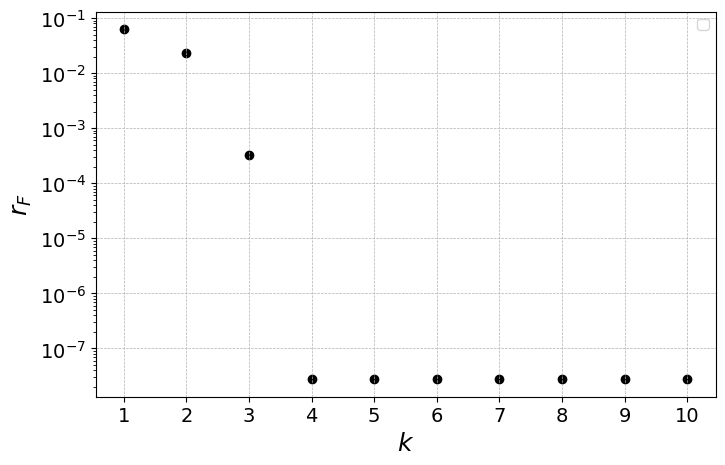

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[5.873e-02 5.035e-08 4.724e-08 4.259e-08 4.064e-08 3.952e-08 3.864e-08
 3.800e-08 3.756e-08 3.689e-08]
1 · ∂α² p + ∂α u_β · ∂β u_α = 0


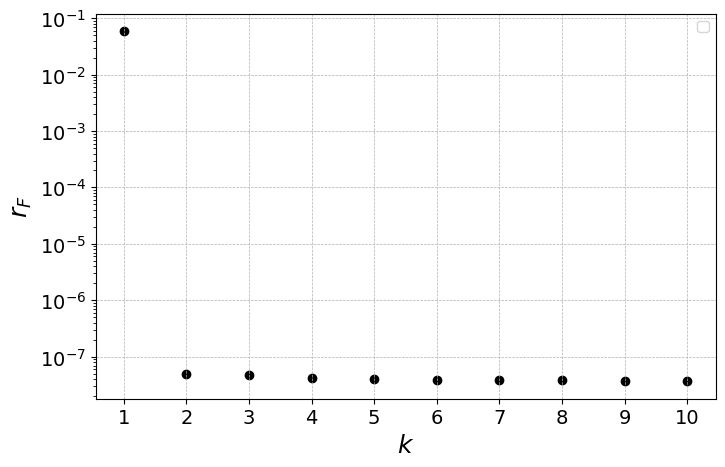

[1.455e-01 8.520e-04 2.820e-07 2.681e-07 2.643e-07 2.623e-07 2.605e-07
 2.589e-07 2.580e-07 2.572e-07]
u_α · ∂γ² u_β + -0.0001 · ∂α ∂γ² u_β + 1 · ∂t ∂α u_β = 0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


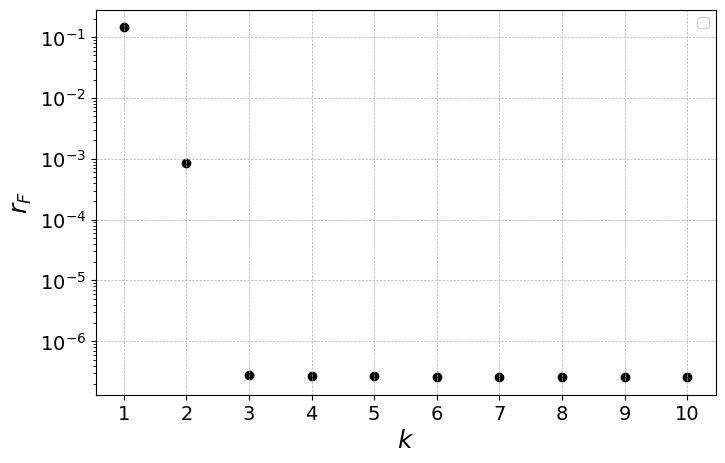

[4.863e-02 2.374e-07 2.325e-07 2.309e-07 2.294e-07 2.270e-07 2.257e-07
 2.244e-07 2.233e-07 2.223e-07]
1 · ∂α u_γ · ∂β u_γ + ∂γ u_α · ∂γ u_β = 0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


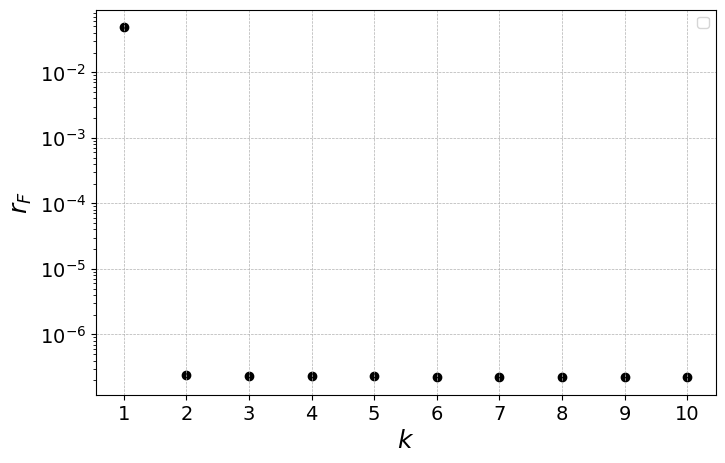

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[6.553e-03 5.872e-03 5.365e-03 5.209e-04 2.898e-07 2.892e-07 2.876e-07
 2.860e-07 2.856e-07 2.855e-07]
∂α ∂β p + 1 · u_α · ∂γ² u_β + 1 · u_γ · ∂α ∂β u_γ + -0.0001 · ∂α ∂γ² u_β + 1 · ∂t ∂α u_β = 0


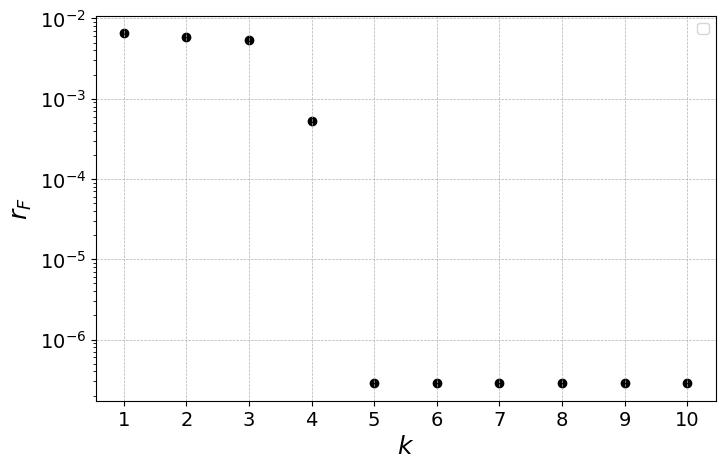

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[6.719e-03 6.021e-03 5.502e-03 1.777e-04 1.169e-04 3.757e-05 4.560e-06
 4.480e-06 4.417e-06 4.410e-06]
1 · ∂α p · u_β + 9.93e-05 · ∂α ∂β p + -1 · u_α · u_γ · ∂β u_γ + 1 · u_α · ∂t u_β + u_γ · u_γ · ∂α u_β + 0.0001 · u_γ · ∂α ∂β u_γ + 0.0001 · ∂t ∂α u_β = 0


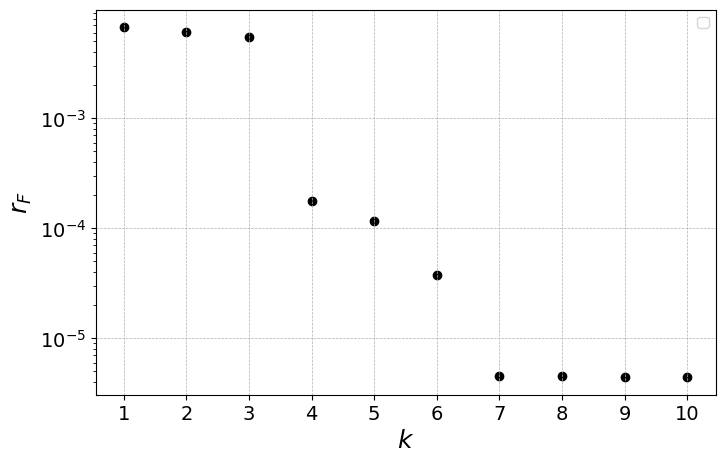

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = False
for i, res in enumerate(reg_results):
    if len(eqs[i].terms)>1:
        all_lambdas = res.all_lambdas
        print(all_lambdas)
        all_xis = res.all_xis
        xi_values = res.xi
        sublibrary_terms = res.sublibrary
        equations = []
        #print(eqs[i].coeffs)
        #equation_terms = [f"{xi:.1e} {term}" for xi, term in zip(xi_values, sublibrary_terms) if abs(xi) > 1e-15]
        #equation_string = " + ".join(equation_terms)
        equation_string = str(eqs[i].pstr(**{'num_format': '{0:.3g}', 'latex_output': False}))
        print(equation_string)
    
        
        plt.figure(figsize=(8, 5))
        #plt.scatter(range(2, len(all_lambdas) + 1), all_lambdas[1:], color='k')#, label="Lambda values") # range(1, 
        plt.scatter(range(1, len(all_lambdas) + 1), all_lambdas, color='k')#, label="Lambda values")

        
        # Set log scale for y-axis
        plt.yscale("log")

        fs = 18
        fs2 = 14
        plt.xlabel("$k$", fontsize=fs)
        plt.ylabel("$r_F$", fontsize=fs)
        #plt.title(f"Equation: {equation_string}")  # Use the computed equation as the title
        #plt.xticks(range(2, len(all_lambdas) + 1), fontsize=fs2)  # Ensure x-axis ticks match the number of equations
        plt.xticks(range(1, len(all_lambdas) + 1), fontsize=fs2)  # Ensure x-axis ticks match the number of equations

        plt.yticks(fontsize=fs2)
        plt.legend()
        plt.grid(True, linestyle="--", linewidth=0.5) # which="both"

        name = f'cont_pareto_{i}.eps'
        plt.savefig(name, bbox_inches='tight', format='eps') # dpi=300,
        
        plt.show()

In [10]:
print(libs[srd.irreps[0]].terms)

[p, p · p, p · p · p, p · p · p · p, p · p · ∂t p, p · p · u_α · u_α, p · p · ∂α u_α, p · ∂α p · u_α, p · ∂α² p, p · ∂t p, p · ∂t² p, p · u_α · u_α, p · u_α · ∂t u_α, p · ∂α u_α, p · ∂t ∂α u_α, ∂α p · ∂α p, ∂α p · u_α, ∂α p · ∂t u_α, ∂α² p, ∂t p, ∂t p · ∂t p, ∂t p · u_α · u_α, ∂t p · ∂α u_α, ∂t ∂α p · u_α, ∂t ∂α² p, ∂t² p, ∂t³ p, u_α · u_α, u_α · u_α · u_β · u_β, u_α · u_β · ∂α u_β, u_α · u_α · ∂β u_β, u_α · ∂β² u_α, u_α · ∂α ∂β u_β, u_α · ∂t u_α, u_α · ∂t² u_α, ∂α u_α, ∂α u_β · ∂β u_α, ∂α u_β · ∂α u_β, ∂α u_α · ∂β u_β, ∂α² ∂β u_β, ∂t u_α · ∂t u_α, ∂t ∂α u_α, ∂t² ∂α u_α]


In [11]:
for k, v in derived_eqs.items():
    print(k, v)
    #for k2, v2 in v.items():
    #    print(k2, len(v2))
for k, v in excluded_terms.items():
    print(len(v), v)

Rank 0 {'∂α u_α = 0': [∂α u_α, ∂t ∂α u_α, ∂t² ∂α u_α, p · ∂t ∂α u_α, ∂α² ∂β u_β, u_α · ∂α ∂β u_β, ∂α u_α · ∂β u_β, ∂t p · ∂α u_α, u_α · ∂α ∂β u_β + ∂α u_α · ∂β u_β, u_α · u_α · ∂β u_β, p · ∂α u_α, p · ∂t ∂α u_α + ∂t p · ∂α u_α, p · p · ∂α u_α], '1 · ∂α p + 1 · u_β · ∂β u_α + -0.0001 · ∂β² u_α + ∂t u_α = 0': [0.9999999291859571 · ∂α² p + 0.9999999073871246 · u_α · ∂α ∂β u_β + 0.9999999073871246 · ∂α u_β · ∂β u_α + -9.999992318938582e-05 · ∂α² ∂β u_β + ∂t ∂α u_α, 0.9999999291859571 · ∂α p · u_α + 0.9999999073871246 · u_α · u_β · ∂α u_β + -9.999992318938582e-05 · u_α · ∂β² u_α + u_α · ∂t u_α], '1 · ∂α² p + ∂α u_β · ∂β u_α = 0': [0.9999999700467086 · ∂α² p + ∂α u_β · ∂β u_α]}
Rank 1 {'∂α u_α = 0': [∂t ∂α ∂β u_β, u_α · ∂t ∂β u_β, ∂α ∂β u_β, ∂t ∂α ∂β u_β, p · ∂α ∂β u_β, ∂β u_β · ∂t u_α, ∂α p · ∂β u_β, u_α · ∂β u_β, u_α · ∂t ∂β u_β + ∂β u_β · ∂t u_α, p · u_α · ∂β u_β, p · ∂α ∂β u_β + ∂α p · ∂β u_β, p · u_α · ∂β u_β], '1 · ∂α p + 1 · u_β · ∂β u_α + -0.0001 · ∂β² u_α + ∂t u_α = 0': [0.999999929

In [12]:
Q = libs[srd.irreps[-1]].Q
terms = libs[srd.irreps[-1]].terms
opts['scaler'].reset_inds(list(range(len(terms))))

print(terms, terms[21])

[p · p · u_α · u_β, p · p · ∂α u_β, p · ∂α p · u_β, p · ∂α ∂β p, p · u_α · u_β, p · u_α · ∂t u_β, p · ∂α u_β, p · ∂t ∂α u_β, ∂α p · ∂β p, ∂α p · u_β, ∂α p · ∂t u_β, ∂α ∂β p, ∂t p · u_α · u_β, ∂t p · ∂α u_β, ∂t ∂α p · u_β, ∂t ∂α ∂β p, u_α · u_β, u_α · u_β · u_γ · u_γ, u_α · u_γ · ∂γ u_β, u_α · u_γ · ∂β u_γ, u_α · u_β · ∂γ u_γ, u_γ · u_γ · ∂α u_β, u_α · ∂γ² u_β, u_γ · ∂α ∂β u_γ, u_α · ∂β ∂γ u_γ, u_γ · ∂α ∂γ u_β, u_α · ∂t u_β, u_α · ∂t² u_β, ∂α u_β, ∂γ u_α · ∂γ u_β, ∂α u_γ · ∂β u_γ, ∂α u_β · ∂γ u_γ, ∂α u_γ · ∂γ u_β, ∂α ∂γ² u_β, ∂α ∂β ∂γ u_γ, ∂t u_α · ∂t u_β, ∂t ∂α u_β, ∂t² ∂α u_β] u_γ · u_γ · ∂α u_β


In [13]:
# coeffs = np.zeros(len(terms))
# coeffs[9] = 1
# coeffs[23] = -1e-4
# coeffs[26] = 1
# coeffs[35] = 1
# opts['scaler'].reset_inds([9, 23, 26, 35])
# reg_result = sparse_reg_bf(Q, **opts)
# #lambd = evaluate_model(Q, coeffs, opts['scaler'], opts['residual'])
# print(reg_result.xi[np.ix_([9, 23, 26, 35])], reg_result.lambd)
# #print(np.linalg.norm(Q[:, 33])/libs[irrep].col_weights[33])
# #print(np.linalg.norm(Q, axis=0)/libs[irrep].col_weights)

In [14]:
i=21
opts['inhomog'] = True
opts['inhomog_col'] = i
opts['verbose'] = False
opts['term_names'] = terms
print(terms[i])
reg_result = sparse_reg_bf(Q, **opts)
print(reg_result.xi, reg_result.lambd)
for i, x in enumerate(reg_result.xi):
    if x!=0:
        print('term', i, '--', reg_result.xi[i], '*', terms[i])

u_γ · u_γ · ∂α u_β
[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -1. -1.  1.  1. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0.] 4.1772138051466875e-17
term 18 -- -0.9999999998521978 * u_α · u_γ · ∂γ u_β
term 19 -- -0.9999999998521978 * u_α · u_γ · ∂β u_γ
term 20 -- 1.0 * u_α · u_β · ∂γ u_γ
term 21 -- 0.999999999852198 * u_γ · u_γ · ∂α u_β


In [15]:
for term in libs[srd.irreps[0]].terms:
    print(term)

p
p · p
p · p · p
p · p · p · p
p · p · ∂t p
p · p · u_α · u_α
p · p · ∂α u_α
p · ∂α p · u_α
p · ∂α² p
p · ∂t p
p · ∂t² p
p · u_α · u_α
p · u_α · ∂t u_α
p · ∂α u_α
p · ∂t ∂α u_α
∂α p · ∂α p
∂α p · u_α
∂α p · ∂t u_α
∂α² p
∂t p
∂t p · ∂t p
∂t p · u_α · u_α
∂t p · ∂α u_α
∂t ∂α p · u_α
∂t ∂α² p
∂t² p
∂t³ p
u_α · u_α
u_α · u_α · u_β · u_β
u_α · u_β · ∂α u_β
u_α · u_α · ∂β u_β
u_α · ∂β² u_α
u_α · ∂α ∂β u_β
u_α · ∂t u_α
u_α · ∂t² u_α
∂α u_α
∂α u_β · ∂β u_α
∂α u_β · ∂α u_β
∂α u_α · ∂β u_β
∂α² ∂β u_β
∂t u_α · ∂t u_α
∂t ∂α u_α
∂t² ∂α u_α


In [16]:
print(srd.scale_dict)
for irrep in srd.irreps:
    # don't forget preprocessing
    Q = srd.libs[irrep].Q/srd.libs[irrep].col_weights # reweight columns
    for i in range(Q.shape[0]): # normalize rows
        Q[i, :] /= np.linalg.norm(Q[i, :])
    [U, S, V] = np.linalg.svd(Q)
    print(np.linalg.norm(Q)/max(S))

{'p': {'mean': np.float64(0.08393930372103373), 'std': np.float64(0.08393930372103378)}, 'u': {'mean': np.float64(0.28155178895306154), 'std': np.float64(0.28155178895306104)}}
1.3031589180423158
1.7871860952239478
1.1844292714437856
1.470292933808732


In [17]:
print([reg_result.sublibrary for reg_result in reg_results])

[[p, p · p, ∂t p, u_α · u_α, ∂α u_α], [p · p · u_α, p · ∂α p, p · u_α, p · ∂t u_α, ∂α p, ∂t p · u_α, ∂t ∂α p, u_α, u_α · u_β · u_β, u_β · ∂α u_β, u_β · ∂β u_α, ∂β² u_α, ∂t u_α, ∂t² u_α], [p, p · p, p · p · p, p · p · p · p, p · p · ∂t p, p · p · u_α · u_α, p · ∂α p · u_α, p · ∂α² p, p · ∂t p, p · ∂t² p, p · u_α · u_α, p · u_α · ∂t u_α, ∂α p · ∂α p, ∂α p · u_α, ∂α p · ∂t u_α, ∂α² p, ∂t p, ∂t p · ∂t p, ∂t p · u_α · u_α, ∂t ∂α p · u_α, ∂t ∂α² p, ∂t² p, ∂t³ p, u_α · u_α, u_α · u_α · u_β · u_β, u_α · ∂β² u_α, u_α · ∂t u_α, u_α · ∂t² u_α, ∂α u_β · ∂β u_α, ∂α u_β · ∂α u_β, ∂t u_α · ∂t u_α], [p · p · ∂α u_β, p · ∂α p · u_β, p · u_α · ∂t u_β, p · ∂α u_β, p · ∂t ∂α u_β, ∂α p · u_β, ∂α p · ∂t u_β, ∂t p · ∂α u_β, ∂t ∂α p · u_β, u_α · u_γ · ∂β u_γ, u_γ · u_γ · ∂α u_β, u_α · ∂γ² u_β, u_α · ∂t u_β, u_α · ∂t² u_β, ∂α u_β, ∂α u_γ · ∂γ u_β, ∂α ∂γ² u_β, ∂t ∂α u_β, ∂t² ∂α u_β], [p · p · ∂α u_β, p · ∂α p · u_β, p · u_α · ∂t u_β, p · ∂α u_β, p · ∂t ∂α u_β, ∂α p · u_β, ∂α p · ∂t u_β, ∂t p · ∂α u_β, ∂t ∂α p ·

In [18]:
from library import latexify

for irrep in srd.irreps:
    print(f"IRREP: {irrep}")
    print(latexify(str(srd.libs[irrep].terms)))
    #for term in srd.libs[irrep].terms:
    #    print(latexify(str(term))+",")

IRREP: Rank 0
[p, p \cdot p, p \cdot p \cdot p, p \cdot p \cdot p \cdot p, p \cdot p \cdot \partial_t p, p \cdot p \cdot u_{\alpha} \cdot u_{\alpha}, p \cdot p \cdot \partial_\alpha u_{\alpha}, p \cdot \partial_\alpha p \cdot u_{\alpha}, p \cdot \partial_\alpha^2 p, p \cdot \partial_t p, p \cdot \partial_t^2 p, p \cdot u_{\alpha} \cdot u_{\alpha}, p \cdot u_{\alpha} \cdot \partial_t u_{\alpha}, p \cdot \partial_\alpha u_{\alpha}, p \cdot \partial_t \partial_\alpha u_{\alpha}, \partial_\alpha p \cdot \partial_\alpha p, \partial_\alpha p \cdot u_{\alpha}, \partial_\alpha p \cdot \partial_t u_{\alpha}, \partial_\alpha^2 p, \partial_t p, \partial_t p \cdot \partial_t p, \partial_t p \cdot u_{\alpha} \cdot u_{\alpha}, \partial_t p \cdot \partial_\alpha u_{\alpha}, \partial_t \partial_\alpha p \cdot u_{\alpha}, \partial_t \partial_\alpha^2 p, \partial_t^2 p, \partial_t^3 p, u_{\alpha} \cdot u_{\alpha}, u_{\alpha} \cdot u_{\alpha} \cdot u_{\beta} \cdot u_{\beta}, u_{\alpha} \cdot u_{\beta} \c

In [19]:
U, S, V = np.linalg.svd(Q)
print(S/S[0])
print("First", V[:, -1])
print("Second", V[:, -2])
print("Third", V[:, -3])
print("Fourth", V[:, -4])

[1.000e+00 7.057e-01 4.180e-01 3.406e-01 2.763e-01 2.649e-01 2.286e-01
 2.082e-01 1.664e-01 1.402e-01 1.245e-01 1.107e-01 1.007e-01 9.533e-02
 8.984e-02 8.015e-02 7.709e-02 7.063e-02 6.300e-02 4.950e-02 4.064e-02
 3.574e-02 2.579e-02 2.289e-02 1.807e-02 1.226e-02 1.025e-02 6.658e-03
 6.856e-06 5.725e-07 2.817e-07 1.945e-07 4.516e-08 1.614e-09 7.112e-17
 7.112e-17 7.112e-17 7.112e-17]
First [ 2.396e-01  4.120e-02  1.663e-01 -7.798e-01  4.927e-01  1.579e-01
 -1.070e-01 -8.684e-02  5.983e-02 -3.701e-02 -6.210e-02  1.260e-02
 -2.902e-02 -1.443e-02  3.473e-02 -6.419e-02  1.489e-02 -3.157e-02
 -1.769e-03  3.959e-02  1.211e-02  1.134e-02 -2.466e-03 -5.279e-03
  2.622e-03  4.045e-06 -3.258e-03 -1.311e-03  4.732e-08  5.007e-08
  1.274e-07 -1.169e-08  1.199e-08 -3.914e-10 -2.220e-16  2.776e-17
  1.110e-16  0.000e+00]
Second [-2.959e-03 -1.740e-02 -1.542e-01 -2.407e-01 -2.642e-01 -1.986e-01
 -8.432e-03  5.643e-02 -3.334e-03 -1.511e-01 -3.303e-02 -6.340e-03
 -1.428e-02  9.911e-02 -6.337e-03 -1.346